# Exercise 2b: Feature engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('/Users/keisukekonno/Documents/NTNU/ML_in_Practice/assignment')

In [3]:
X_train = pd.read_csv("ex2_train.csv")
y_train = pd.read_csv("ex2_class_train.csv")
X_test = pd.read_csv("ex2_test.csv")
y_test = pd.read_csv("ex2_class_test.csv")

In [4]:
def evaluate_result(X_test, y_test, clf):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'AUC-ROC: {auc_roc:.4f}')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC-ROC': auc_roc
    }

## Prototyping (without feature engineering)

In [5]:
def preprocess(data_in):
    df = data_in.copy()
    data = df.drop(columns=['Name'])
    
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)

    # Convert categorical variables to dummy/indicator variables
    data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

    return data

In [6]:
X_train_processed_tmp = preprocess(X_train)
X_test_processed_tmp = preprocess(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_processed_tmp, y_train.values.ravel())
y_pred = clf.predict(X_test_processed_tmp)

print('Random Forest Model without Feature Engineering')
original_scores = evaluate_result(X_test_processed_tmp, y_test, clf)

# store the scores in a dictionary
scores = {}
scores['Original'] = original_scores

Random Forest Model without Feature Engineering
Accuracy: 0.8101
Precision: 0.7778
Recall: 0.7568
F1-score: 0.7671
AUC-ROC: 0.8736


## Let's visualize correlation before feature engineering

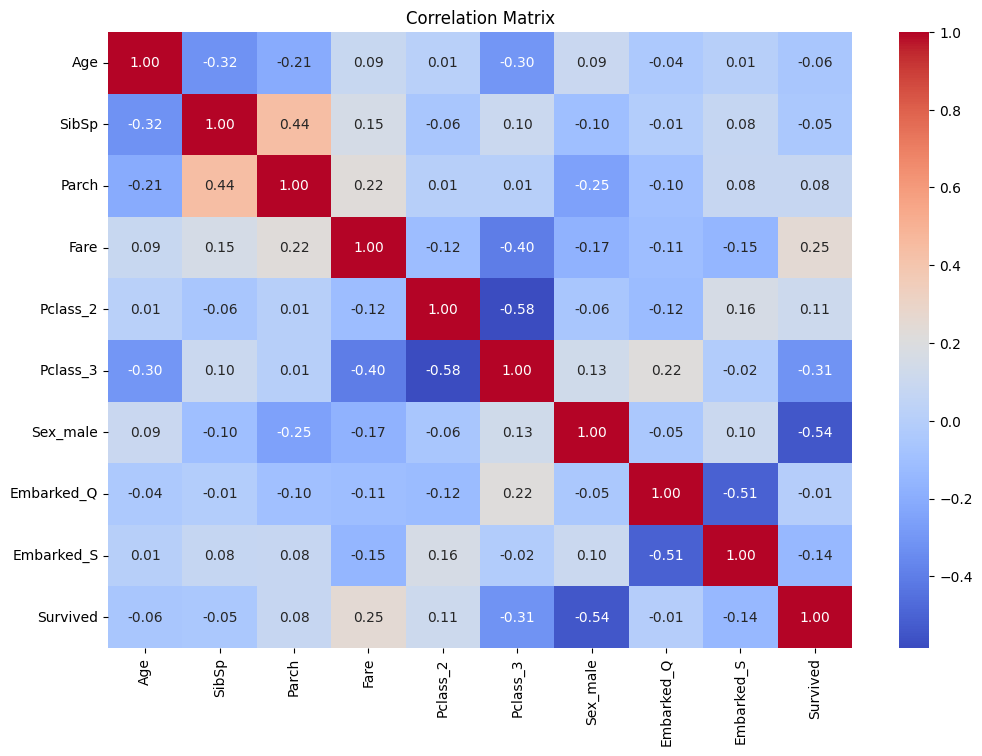

In [7]:
# One-hot encoding on Pclass, Sex, Embarked
corr_df = pd.get_dummies(X_train, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)

# Add y_train to the correlation matrix
corr_df = corr_df.drop(columns=['Name'])
corr_df['Survived'] = y_train
corr_df = corr_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature engineering

The classification using simple preprocessed data gives only mediocre performance.

**TODO: You should make use of the insights from your EDA (ex2a) to complete the following feature engineering function below.** Later the function will replace the simple preprocessing.

You will pass the exercise if your feature engineering can improve the performance (i.e., winning in three or more metrics).

## Grouping Titles

In [8]:
def process_titles(df):
    # Extract titles from names
    df['Title'] = df['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
    
    # Group titles into smaller categories
    df['NewTitle'] = df['Title'].map({
        'Master': 'Master',
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Miss': 'Miss'
    }).fillna('Other')
    
    # Assign 'Mr' to adult males
    df.loc[(df['Sex'] == 'male') & (df['NewTitle'] != 'Master'), 'NewTitle'] = 'Mr'
    
    # Assign 'Mrs' to adult females not already categorized as 'Miss'
    df.loc[(df['Sex'] == 'female') & (df['NewTitle'] == 'Other'), 'NewTitle'] = 'Mrs'
    
    return df

# Apply the function to X_train_processed
X_train_processed = process_titles(X_train)
X_test_processed = process_titles(X_test)

print(X_train_processed[['Name', 'Title', 'NewTitle']].head())
print(X_train_processed['NewTitle'].unique())

                                 Name Title NewTitle
0                 Partner, Mr. Austen    Mr       Mr
1          Berriman, Mr. William John    Mr       Mr
2                  Tikkanen, Mr. Juho    Mr       Mr
3             Hansen, Mr. Henrik Juul    Mr       Mr
4  Andersson, Miss. Ebba Iris Alfrida  Miss     Miss
['Mr' 'Miss' 'Mrs' 'Master']


## Family Size

In [9]:
def family_size(df):
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    return df

# Apply the function to X_train_processed
X_train_processed = family_size(X_train_processed)
X_test_processed = family_size(X_test_processed)

print(X_train_processed[['Parch', 'SibSp', 'FamilySize']].head())

   Parch  SibSp  FamilySize
0      0      0           1
1      0      0           1
2      0      0           1
3      0      1           2
4      2      4           7


## Null values in Age and Embarked

In [10]:
from sklearn.impute import SimpleImputer


def fill_null_values(df):
    # Use SimpleImputer to fill missing values
    imputer = SimpleImputer(strategy='most_frequent')
    # Reshape the data to 2D array
    embarked_2d = df['Embarked'].values.reshape(-1, 1)
    # Fit and transform the data
    df['Embarked'] = imputer.fit_transform(embarked_2d).ravel()

    # Use SimpleImputer to fill missing values
    imputer = SimpleImputer(strategy='mean')
    # Reshape the data to 2D array
    age_2d = df['Age'].values.reshape(-1, 1)
    # Fit and transform the data
    df['Age'] = imputer.fit_transform(age_2d).ravel()
    
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = fill_null_values(X_train_processed)
X_test_processed = fill_null_values(X_test_processed)

# Check the result
print(X_train_processed['Embarked'].isnull().sum())
print(X_test_processed['Embarked'].isnull().sum())
print(X_train_processed['Age'].isnull().sum())
print(X_test_processed['Age'].isnull().sum())

0
0
0
0


## One-hot encoding on NewTitle, Embarked, Sex, Pclass

In [11]:
from sklearn.preprocessing import OrdinalEncoder


def one_hot_encoding(df):
    # Use one-hot encoder for NewTitle and Embarked
    df = pd.get_dummies(df, columns=['NewTitle', 'Embarked'], drop_first=True)
    # Use OrdinalEncoder for Pclass and Sex
    oe = OrdinalEncoder()
    df.loc[:,['PclassEncoded', 'SexEncoded']] = oe.fit_transform(df.loc[:,['Pclass', 'Sex']])
    
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = one_hot_encoding(X_train_processed)
X_test_processed = one_hot_encoding(X_test_processed)

## Drop the unnecessary columns

In [12]:
def drop_unnecessary_columns(df):
    # df = df.drop(columns=['Name', 'Title', 'SibSp', 'Parch', 'Fare', 'Age', 'Sex', 'Pclass'])
    df = df.drop(columns=['Name', 'Title', 'Sex'])
    return df

# Apply the function to X_train_processed and X_test_processed
X_train_processed = drop_unnecessary_columns(X_train_processed)
X_test_processed = drop_unnecessary_columns(X_test_processed)

## Check the transformed data

In [13]:
print(X_train_processed.info())
print(X_test_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Age            712 non-null    float64
 2   SibSp          712 non-null    int64  
 3   Parch          712 non-null    int64  
 4   Fare           712 non-null    float64
 5   FamilySize     712 non-null    int64  
 6   NewTitle_Miss  712 non-null    bool   
 7   NewTitle_Mr    712 non-null    bool   
 8   NewTitle_Mrs   712 non-null    bool   
 9   Embarked_Q     712 non-null    bool   
 10  Embarked_S     712 non-null    bool   
 11  PclassEncoded  712 non-null    float64
 12  SexEncoded     712 non-null    float64
dtypes: bool(5), float64(4), int64(4)
memory usage: 48.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -

## Check correlation after feature engineering

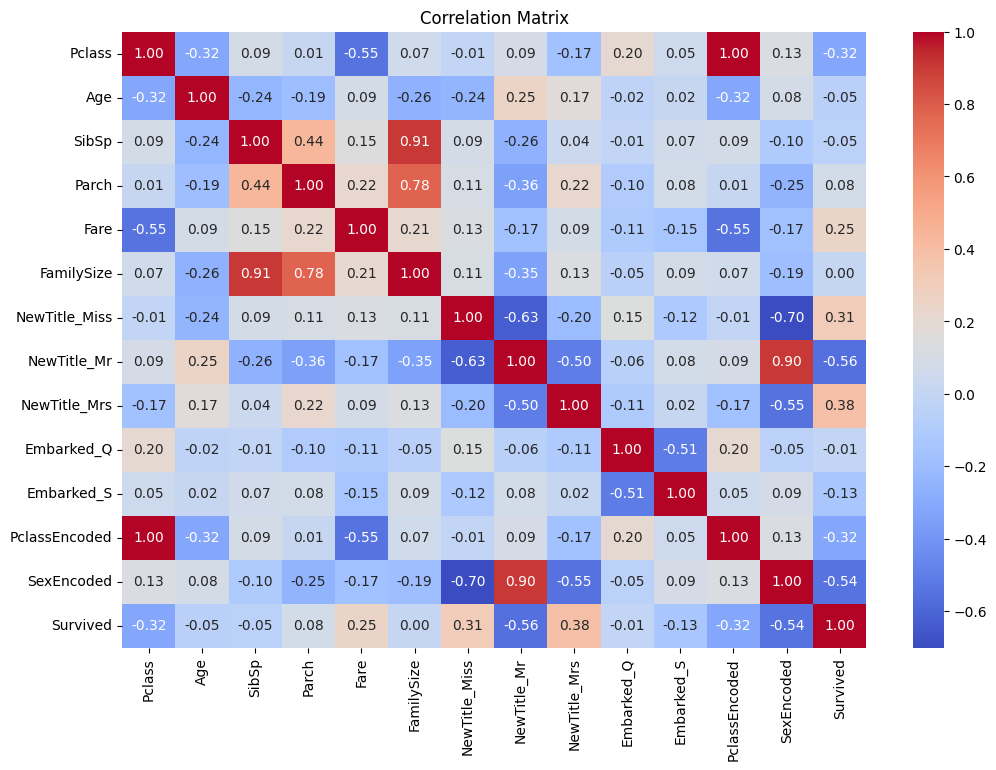

In [14]:
# add y_train to X_train_processed
corr_df = X_train_processed.copy()
corr_df['Survived'] = y_train

# Calculate the correlation matrix
corr_matrix = corr_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Grid Search

Randomized Search Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 0.9093204020787821, 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 409}
Randomized Search Best validation score: 0.7664240719113902
Randomized Search Best training score: 0.8412921348314607

               precision    recall  f1-score   support

           0       0.85      0.91      0.88       444
           1       0.83      0.73      0.78       268

    accuracy                           0.84       712
   macro avg       0.84      0.82      0.83       712
weighted avg       0.84      0.84      0.84       712



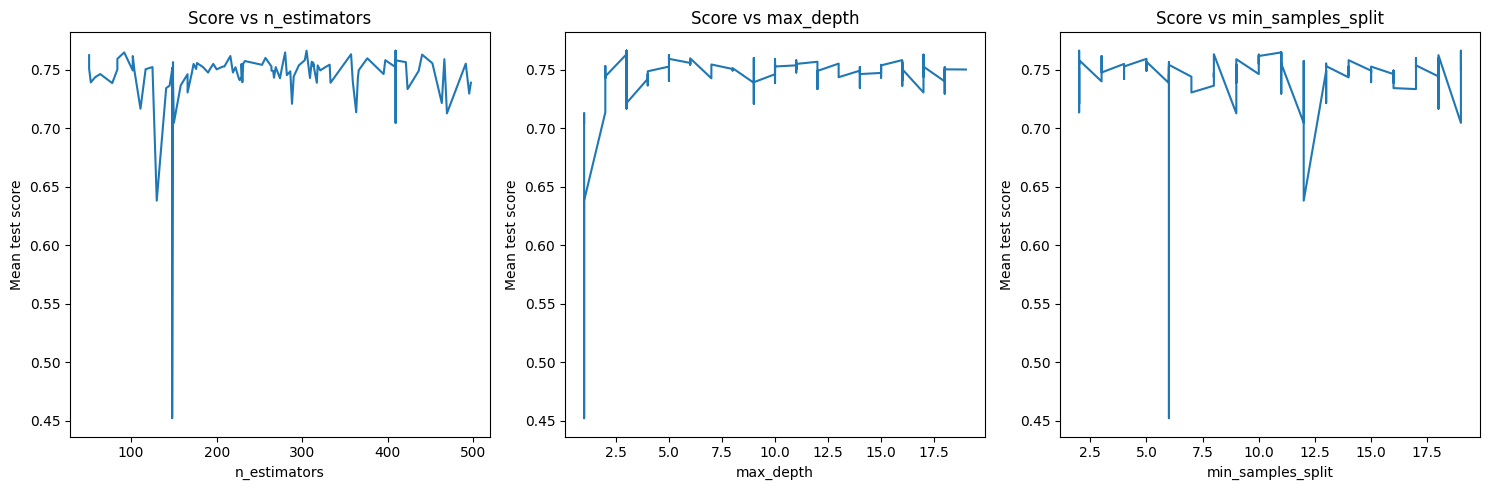

CPU times: user 2.19 s, sys: 1.62 s, total: 3.81 s
Wall time: 11.6 s


In [15]:
%%time

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform

def fit_and_visualize(classifier, param_dist, X, y, n_iter=100):
    rscv = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=n_iter, cv=5, scoring='f1', n_jobs=-1, random_state=42)
    rscv.fit(X, y)

    print('Randomized Search Best parameters:', rscv.best_params_)
    print('Randomized Search Best validation score:', rscv.best_score_)
    print('Randomized Search Best training score:', rscv.best_estimator_.score(X, y))

    X_pred = rscv.best_estimator_.predict(X)
    print('\n', classification_report(y, X_pred))

    # Visualize results
    results = rscv.cv_results_
    params = ['n_estimators', 'max_depth', 'min_samples_split']  # Choose top 3 parameters to visualize

    # Create a figure with subplots for each parameter
    fig, axes = plt.subplots(1, len(params), figsize=(15, 5))

    for idx, param_name in enumerate(params):
        param_values = results['param_' + param_name].data
        scores = results['mean_test_score']
        
        # Sort the values and scores
        sorted_idx = np.argsort(param_values)
        sorted_values = np.array(param_values)[sorted_idx]
        sorted_scores = np.array(scores)[sorted_idx]
        
        ax = axes[idx]
        ax.plot(sorted_values, sorted_scores)
        ax.set_xlabel(param_name)
        ax.set_ylabel('Mean test score')
        ax.set_title(f'Score vs {param_name}')

    plt.tight_layout()
    plt.show()

    return rscv.best_estimator_

# Example usage:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0, 1),
    'bootstrap': [True, False]
}

rf_best = fit_and_visualize(RandomForestClassifier(random_state=44), param_dist, 
                            X_train_processed, y_train.values.ravel())

## Auto Feature Selection

In [20]:
# Auto Feature Selection 
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV


def auto_feature_selection(X, y, estimator, param_grid, cv=5):
    """
    Perform automatic feature selection using grid search.
    
    Args:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Target variable
    estimator: The estimator to use (e.g., RandomForestClassifier)
    param_grid (dict): Parameter grid for the estimator
    cv (int): Number of cross-validation folds
    
    Returns:
    tuple: Best features, best estimator
    """
    # Create the RFE object and compute a cross-validated score
    rfe = RFE(estimator=estimator)
    
    # Combine RFE with GridSearchCV
    grid_rfe = GridSearchCV(estimator=rfe, 
                            param_grid=param_grid, 
                            cv=cv, 
                            scoring='accuracy',
                            n_jobs=-1)
    
    # Fit the GridSearchCV object to the data
    grid_rfe.fit(X, y)
    
    # Get the optimal number of features
    n_features_optimal = grid_rfe.best_estimator_.n_features_
    
    # Get the mask of selected features
    feature_mask = grid_rfe.best_estimator_.support_
    
    # Get the list of selected feature names
    selected_features = X.columns[feature_mask].tolist()
    
    print(f"Optimal number of features: {n_features_optimal}")
    print("Selected features:")
    for feature in selected_features:
        print(f"- {feature}")
    
    return selected_features, grid_rfe.best_estimator_.estimator_

# Example usage:
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [5, 10, None],
    'n_features_to_select': [5, 10, 15, 20]  # You can adjust this based on your dataset
}

selected_features, best_rf = auto_feature_selection(X_train_processed, y_train.values.ravel(), 
                                                    RandomForestClassifier(random_state=44), 
                                                    param_grid)

# Use selected features for further modeling
X_train_selected = X_train_processed[selected_features]
X_test_selected = X_test_processed[selected_features]

# Train a new model with selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=44)
rf_selected.fit(X_train_selected, y_train.values.ravel())

# Evaluate the model
print('Random Forest Model with Auto Feature Selection')
scores['Auto Feature Selection'] = evaluate_result(X_test_selected, y_test, rf_selected)


Optimal number of features: 13
Selected features:
- Pclass
- Age
- SibSp
- Parch
- Fare
- FamilySize
- NewTitle_Miss
- NewTitle_Mr
- NewTitle_Mrs
- Embarked_Q
- Embarked_S
- PclassEncoded
- SexEncoded
Random Forest Model with Auto Feature Selection
Accuracy: 0.8436
Precision: 0.8194
Recall: 0.7973
F1-score: 0.8082
AUC-ROC: 0.8949


In [21]:
print('Random Forest Model with Auto Feature Selection')
scores['Auto Feature Selection'] = evaluate_result(X_test_selected, y_test, rf_selected)

# Show how much scores have improved
print('Improvement in scores after feature engineering:')
for metric in scores['Feature Engineering']:
    print(f'{metric}: {scores["Auto Feature Selection"][metric] - scores["Original"][metric]:.4f}')

Random Forest Model with Auto Feature Selection
Accuracy: 0.8436
Precision: 0.8194
Recall: 0.7973
F1-score: 0.8082
AUC-ROC: 0.8949
Improvement in scores after feature engineering:
Accuracy: 0.0335
Precision: 0.0417
Recall: 0.0405
F1-score: 0.0411
AUC-ROC: 0.0213


## Model Performance

In [16]:

print('Random Forest Model with Feature Engineering')
scores['Feature Engineering'] = evaluate_result(X_test_processed, y_test, rf_best)

Random Forest Model with Feature Engineering
Accuracy: 0.8212
Precision: 0.8088
Recall: 0.7432
F1-score: 0.7746
AUC-ROC: 0.8839


In [17]:
# Show how much scores have improved
print('Improvement in scores after feature engineering:')
for metric in scores['Feature Engineering']:
    print(f'{metric}: {scores["Feature Engineering"][metric] - scores["Original"][metric]:.4f}')

Improvement in scores after feature engineering:
Accuracy: 0.0112
Precision: 0.0310
Recall: -0.0135
F1-score: 0.0075
AUC-ROC: 0.0103
